## Word Prediction

In [2]:
import numpy as np 
import matplotlib.pyplot as plt
import tensorflow as tf
import pickle

In [3]:
import unittests

## Defining some useful global variables

Next you will define some global variables that will be used throughout the assignment. Feel free to reference them in the upcoming exercises:

- `FILE_PATH`: The file path where the sonnets file is located. 

- `NUM_BATCHES`: Number of batches. Defaults to 16.
- `LSTM_UNITS`: Number of LSTM units in the LSTM layer.
- `EMBEDDING_DIM`: Number of dimensions in the embedding layer.

In [1]:
FILE_PATH = './data/sonnets.txt'
NUM_BATCHES = 16
LSTM_UNITS = 128
EMBEDDING_DIM = 100

### Reading the dataset

For this assignment you will be using the [Shakespeare Sonnets Dataset](https://www.opensourceshakespeare.org/views/sonnets/sonnet_view.php?range=viewrange&sonnetrange1=1&sonnetrange2=154), which contains more than 2000 lines of text extracted from Shakespeare's sonnets.

In [4]:
# Read the data
with open(FILE_PATH) as f:
    data = f.read()

# Convert to lower case and save as a list
corpus = data.lower().split("\n")

print(f"There are {len(corpus)} lines of sonnets\n")
print(f"The first 5 lines look like this:\n")
for i in range(5):
  print(corpus[i])

There are 2159 lines of sonnets

The first 5 lines look like this:

from fairest creatures we desire increase,
that thereby beauty's rose might never die,
but as the riper should by time decease,
his tender heir might bear his memory:
but thou, contracted to thine own bright eyes,


In [5]:
def fit_vectorizer(corpus):
    """
    Instantiates the vectorizer class on the corpus
    
    Args:
        corpus (list): List with the sentences.
    
    Returns:
        (tf.keras.layers.TextVectorization): an instance of the TextVectorization class containing the word-index dictionary, adapted to the corpus sentences.
    """    

    tf.keras.utils.set_random_seed(65) # Do not change this line or you may have different expected outputs throughout the assignment

    ### START CODE HERE ###

    # Define the TextVectorization layer
    vectorizer = tf.keras.layers.TextVectorization(
        standardize="lower_and_strip_punctuation", # Lowercase and remove punctuation
        ragged=True                                # To avoid padding automatically
    )
    
    # Adapt the vectorizer to the corpus
    vectorizer.adapt(corpus)
    
    
    return vectorizer

In [6]:
vectorizer = fit_vectorizer(corpus)
total_words = len(vectorizer.get_vocabulary())
print(f"Total number of words in corpus (including the out of vocabulary): {total_words}")

Total number of words in corpus (including the out of vocabulary): 3189


**Expected output:**

```
Total number of words in corpus (including the out of vocabulary): 3189
```

One thing to note is that you can either pass a string or a list of strings to vectorizer. If you pass the former, it will return a *tensor* whereas if you pass the latter, it will return a *ragged tensor* if you've correctly configured the TextVectorization layer to do so.

In [7]:
print(f"Passing a string directly: {vectorizer('This is a test string').__repr__()}")
print(f"Passing a list of strings: {vectorizer(['This is a test string'])}")

Passing a string directly: <tf.Tensor: shape=(5,), dtype=int64, numpy=array([  29,   14,   18,    1, 1679])>
Passing a list of strings: <tf.RaggedTensor [[29, 14, 18, 1, 1679]]>


**Expected output:**

```
Passing a string directly: <tf.Tensor: shape=(5,), dtype=int64, numpy=array([  29,   14,   18,    1, 1679])>
Passing a list of strings: <tf.RaggedTensor [[29, 14, 18, 1, 1679]]>
```

In [9]:
# Test your code!
unittests.test_fit_vectorizer(fit_vectorizer)

 All tests passed!


## Generating n-grams

In [38]:
# GRADED FUNCTION: n_gram_seqs

def n_gram_seqs(corpus, vectorizer):
    """
    Generates a list of n-gram sequences
    
    Args:
        corpus (list of string): lines of texts to generate n-grams for
        vectorizer (tf.keras.layers.TextVectorization): an instance of the TextVectorization class adapted in the corpus
    
    Returns:
        (list of tf.int64 tensors): the n-gram sequences for each line in the corpus
    """
    input_sequences = []

    for sentence in corpus:
        # Vectorize the sentence
        vectorized_sentence = vectorizer(tf.constant([sentence]))[0].numpy()
        
        # Generate n-grams of length 2 up to the length of the sentence
        for i in range(2, len(vectorized_sentence) + 1):
            n_gram_sequence = vectorized_sentence[:i]
            input_sequences.append(n_gram_sequence)
    
    # Remove the first sequence if it is all zeros
    if all(x == 0 for x in input_sequences[0]):
        input_sequences = input_sequences[1:]

    
    return input_sequences

In [39]:
# Test your function with one example
first_example_sequence = n_gram_seqs([corpus[0]], vectorizer)

print("n_gram sequences for first example look like this:\n")
first_example_sequence

n_gram sequences for first example look like this:



[array([ 35, 489]),
 array([  35,  489, 1259]),
 array([  35,  489, 1259,  164]),
 array([  35,  489, 1259,  164,  230]),
 array([  35,  489, 1259,  164,  230,  582])]

**Expected Output:**

```
n_gram sequences for first example look like this:

[<tf.Tensor: shape=(2,), dtype=int64, numpy=array([ 35, 489])>,
 <tf.Tensor: shape=(3,), dtype=int64, numpy=array([  35,  489, 1259])>,
 <tf.Tensor: shape=(4,), dtype=int64, numpy=array([  35,  489, 1259,  164])>,
 <tf.Tensor: shape=(5,), dtype=int64, numpy=array([  35,  489, 1259,  164,  230])>,
 <tf.Tensor: shape=(6,), dtype=int64, numpy=array([  35,  489, 1259,  164,  230,  582])>]
```

In [40]:
# Test your function with a bigger corpus
next_3_examples_sequence = n_gram_seqs(corpus[1:4], vectorizer)

print("n_gram sequences for next 3 examples look like this:\n")
next_3_examples_sequence

n_gram sequences for next 3 examples look like this:



[array([  9, 935]),
 array([  9, 935, 143]),
 array([  9, 935, 143, 369]),
 array([  9, 935, 143, 369, 101]),
 array([  9, 935, 143, 369, 101, 171]),
 array([  9, 935, 143, 369, 101, 171, 207]),
 array([17, 23]),
 array([17, 23,  3]),
 array([  17,   23,    3, 1006]),
 array([  17,   23,    3, 1006,   64]),
 array([  17,   23,    3, 1006,   64,   31]),
 array([  17,   23,    3, 1006,   64,   31,   51]),
 array([  17,   23,    3, 1006,   64,   31,   51,  803]),
 array([ 27, 315]),
 array([ 27, 315, 745]),
 array([ 27, 315, 745, 101]),
 array([ 27, 315, 745, 101, 209]),
 array([ 27, 315, 745, 101, 209,  27]),
 array([ 27, 315, 745, 101, 209,  27, 286])]

**Expected Output:**

```
n_gram sequences for next 3 examples look like this:

[<tf.Tensor: shape=(2,), dtype=int64, numpy=array([  9, 935])>,
 <tf.Tensor: shape=(3,), dtype=int64, numpy=array([  9, 935, 143])>,
 <tf.Tensor: shape=(4,), dtype=int64, numpy=array([  9, 935, 143, 369])>,
 <tf.Tensor: shape=(5,), dtype=int64, numpy=array([  9, 935, 143, 369, 101])>,
 <tf.Tensor: shape=(6,), dtype=int64, numpy=array([  9, 935, 143, 369, 101, 171])>,
 <tf.Tensor: shape=(7,), dtype=int64, numpy=array([  9, 935, 143, 369, 101, 171, 207])>,
 <tf.Tensor: shape=(2,), dtype=int64, numpy=array([17, 23])>,
 <tf.Tensor: shape=(3,), dtype=int64, numpy=array([17, 23,  3])>,
 <tf.Tensor: shape=(4,), dtype=int64, numpy=array([  17,   23,    3, 1006])>,
 <tf.Tensor: shape=(5,), dtype=int64, numpy=array([  17,   23,    3, 1006,   64])>,
 <tf.Tensor: shape=(6,), dtype=int64, numpy=array([  17,   23,    3, 1006,   64,   31])>,
 <tf.Tensor: shape=(7,), dtype=int64, numpy=array([  17,   23,    3, 1006,   64,   31,   51])>,
 <tf.Tensor: shape=(8,), dtype=int64, numpy=array([  17,   23,    3, 1006,   64,   31,   51,  803])>,
 <tf.Tensor: shape=(2,), dtype=int64, numpy=array([ 27, 315])>,
 <tf.Tensor: shape=(3,), dtype=int64, numpy=array([ 27, 315, 745])>,
 <tf.Tensor: shape=(4,), dtype=int64, numpy=array([ 27, 315, 745, 101])>,
 <tf.Tensor: shape=(5,), dtype=int64, numpy=array([ 27, 315, 745, 101, 209])>,
 <tf.Tensor: shape=(6,), dtype=int64, numpy=array([ 27, 315, 745, 101, 209,  27])>,
 <tf.Tensor: shape=(7,), dtype=int64, numpy=array([ 27, 315, 745, 101, 209,  27, 286])>]
```

In [41]:
# Test your code!
unittests.test_n_gram_seqs(n_gram_seqs)

Failed test case: Unittest aborted due to an execution error..
Expected: Proper execution of function when passing the following tensors to split:
	[<tf.Tensor: shape=(7,), dtype=int64, numpy=array([589, 457, 163, 583, 190, 641, 467])>]
Got: Thrown exception is: TypeError: Scalar tensor has no `len()`
Traceback (most recent call last):

  File "/usr/local/lib/python3.11/dist-packages/tensorflow/python/framework/ops.py", line 349, in __len__
    raise TypeError("Scalar tensor has no `len()`")

TypeError: Scalar tensor has no `len()`






Apply the `n_gram_seqs` transformation to the whole corpus and save the maximum sequence length to use it later:

In [15]:
# Apply the n_gram_seqs transformation to the whole corpus
input_sequences = n_gram_seqs(corpus, vectorizer)

# Save max length 
max_sequence_len = max([len(x) for x in input_sequences])

print(f"n_grams of input_sequences have length: {len(input_sequences)}")
print(f"maximum length of sequences is: {max_sequence_len}")

n_grams of input_sequences have length: 17511
maximum length of sequences is: 11


## pad_seqs

In [29]:
# GRADED FUNCTION: pad_seqs

def pad_seqs(input_sequences, max_sequence_len):
    """
    Pads tokenized sequences to the same length
    
    Args:
        input_sequences (list of int): tokenized sequences to pad
        maxlen (int): maximum length of the token sequences
    
    Returns:
        (np.array of int32): tokenized sequences padded to the same length
    """
    
     
    # Use tf.keras.utils.pad_sequences to pad the sequences
    padded_sequences = tf.keras.utils.pad_sequences(
        input_sequences, 
        maxlen=max_sequence_len,  # Pad to max_sequence_len
        padding='pre'             # Pad before the sequence (on the left)
    )
    
    return padded_sequences

In [30]:
# Test your function with the n_grams_seq of the first example
first_padded_seq = pad_seqs(first_example_sequence, max([len(x) for x in first_example_sequence]))
first_padded_seq

array([[   0,    0,    0,    0,    0,   35],
       [   0,    0,    0,    0,   35,  489],
       [   0,    0,    0,   35,  489, 1259],
       [   0,    0,   35,  489, 1259,  164],
       [   0,   35,  489, 1259,  164,  230],
       [  35,  489, 1259,  164,  230,  582]], dtype=int32)

**Expected Output:**

```
array([[   0,    0,    0,    0,   35,  489],
       [   0,    0,    0,   35,  489, 1259],
       [   0,    0,   35,  489, 1259,  164],
       [   0,   35,  489, 1259,  164,  230],
       [  35,  489, 1259,  164,  230,  582]], dtype=int32)
```

In [31]:
# Test your function with the n_grams_seq of the next 3 examples
next_3_padded_seq = pad_seqs(next_3_examples_sequence, max([len(s) for s in next_3_examples_sequence]))
next_3_padded_seq

array([[   0,    0,    0,    0,    0,    0,    0,    9],
       [   0,    0,    0,    0,    0,    0,    9,  935],
       [   0,    0,    0,    0,    0,    9,  935,  143],
       [   0,    0,    0,    0,    9,  935,  143,  369],
       [   0,    0,    0,    9,  935,  143,  369,  101],
       [   0,    0,    9,  935,  143,  369,  101,  171],
       [   0,    9,  935,  143,  369,  101,  171,  207],
       [   0,    0,    0,    0,    0,    0,    0,   17],
       [   0,    0,    0,    0,    0,    0,   17,   23],
       [   0,    0,    0,    0,    0,   17,   23,    3],
       [   0,    0,    0,    0,   17,   23,    3, 1006],
       [   0,    0,    0,   17,   23,    3, 1006,   64],
       [   0,    0,   17,   23,    3, 1006,   64,   31],
       [   0,   17,   23,    3, 1006,   64,   31,   51],
       [  17,   23,    3, 1006,   64,   31,   51,  803],
       [   0,    0,    0,    0,    0,    0,    0,   27],
       [   0,    0,    0,    0,    0,    0,   27,  315],
       [   0,    0,    0,    0,

**Expected Output:**

```
array([[   0,    0,    0,    0,    0,    0,    9,  935],
       [   0,    0,    0,    0,    0,    9,  935,  143],
       [   0,    0,    0,    0,    9,  935,  143,  369],
       [   0,    0,    0,    9,  935,  143,  369,  101],
       [   0,    0,    9,  935,  143,  369,  101,  171],
       [   0,    9,  935,  143,  369,  101,  171,  207],
       [   0,    0,    0,    0,    0,    0,   17,   23],
       [   0,    0,    0,    0,    0,   17,   23,    3],
       [   0,    0,    0,    0,   17,   23,    3, 1006],
       [   0,    0,    0,   17,   23,    3, 1006,   64],
       [   0,    0,   17,   23,    3, 1006,   64,   31],
       [   0,   17,   23,    3, 1006,   64,   31,   51],
       [  17,   23,    3, 1006,   64,   31,   51,  803],
       [   0,    0,    0,    0,    0,    0,   27,  315],
       [   0,    0,    0,    0,    0,   27,  315,  745],
       [   0,    0,    0,    0,   27,  315,  745,  101],
       [   0,    0,    0,   27,  315,  745,  101,  209],
       [   0,    0,   27,  315,  745,  101,  209,   27],
       [   0,   27,  315,  745,  101,  209,   27,  286]], dtype=int32)
```

In [32]:
# Test your code!
unittests.test_pad_seqs(pad_seqs)

 All tests passed!


In [33]:
# Pad the whole corpus
input_sequences = pad_seqs(input_sequences, max_sequence_len)

print(f"padded corpus has shape: {input_sequences.shape}")

padded corpus has shape: (17511, 11)


**Expected Output:**

```
padded corpus has shape: (15355, 11)

```

## features_and_labels_dataset

In [47]:
# GRADED FUNCTION: features_and_labels

def features_and_labels_dataset(input_sequences, total_words):
    """
    Generates features and labels from n-grams and returns a tensorflow dataset
    
    Args:
        input_sequences (list of int): sequences to split features and labels from
        total_words (int): vocabulary size
    
    Returns:
        (tf.data.Dataset): Dataset with elements in the form (sentence, label)
    """
    ### START CODE HERE ###

    # Define the features an labels as discussed in the lectures
    # Features are the n-gram sequences without the last word
    input_sequences = np.array(input_sequences)
    
    # Features are the sequences without the last word
    features = input_sequences[:, :-1]
    
    # Labels are the last word of each sequence
    labels = input_sequences[:, -1]
    
    # One-hot encode the labels using the total_words (vocabulary size)
    one_hot_labels = tf.keras.utils.to_categorical(labels, num_classes=total_words)
    
    # Create a dataset from the features and one-hot encoded labels
    dataset = tf.data.Dataset.from_tensor_slices((features, one_hot_labels))
    
    # Batch the dataset using the defined batch size
    batched_dataset = dataset.batch(NUM_BATCHES)

    return batched_dataset

In [48]:
# Test your function with the padded n_grams_seq of the first example
dataset_example = features_and_labels_dataset(first_padded_seq, total_words)

print("Example:\n")
for features, label in dataset_example.take(1):
    print(f"N grams:\n\n {features}\n")
    print(f"Label shape:\n\n {label.shape}")

Example:

N grams:

 [[   0    0    0    0    0]
 [   0    0    0    0   35]
 [   0    0    0   35  489]
 [   0    0   35  489 1259]
 [   0   35  489 1259  164]
 [  35  489 1259  164  230]]

Label shape:

 (6, 3189)


**Expected Output:**

```
Example:

N grams:

 [[   0    0    0    0   35]
 [   0    0    0   35  489]
 [   0    0   35  489 1259]
 [   0   35  489 1259  164]
 [  35  489 1259  164  230]]

Label shape:

 (5, 3189)
```

In [45]:
# Test your code!
unittests.test_features_and_labels_dataset(features_and_labels_dataset)

 All tests passed!


Now let's generate the whole dataset that will be used for training. In this case, let's use the [.prefetch](https://www.tensorflow.org/api_docs/python/tf/data/Dataset#prefetch) method to speed up the training. Since the dataset is not that big, you should not have problems with memory by doing this. 

In [46]:
# Split the whole corpus
dataset = features_and_labels_dataset(input_sequences, total_words).prefetch(tf.data.AUTOTUNE)

print(f"Feature shape: {dataset.element_spec[0]}")
print(f"Label shape: {dataset.element_spec[1]}")

Feature shape: TensorSpec(shape=(None, 10), dtype=tf.int32, name=None)
Label shape: TensorSpec(shape=(None, 3189), dtype=tf.float64, name=None)


**Expected Output:**

```
Feature shape: TensorSpec(shape=(None, 10), dtype=tf.int32, name=None)
Label shape: TensorSpec(shape=(None, 3189), dtype=tf.float32, name=None)
```

## create_model

In [69]:
# GRADED FUNCTION: create_model

def create_model(total_words, max_sequence_len):
    """
    Creates a text generator model
    
    Args:
        total_words (int): size of the vocabulary for the Embedding layer input
        max_sequence_len (int): length of the input sequences
    
    Returns:
       (tf.keras Model): the text generator model
    """
    model = tf.keras.Sequential()

    # Input layer, the input shape is max_sequence_len - 1 because labels are removed
    model.add(tf.keras.layers.Input(shape=(max_sequence_len - 1,)))
    
    # Embedding layer: input_dim is total_words and output_dim is EMBEDDING_DIM (100)
    model.add(tf.keras.layers.Embedding(input_dim=total_words, output_dim=EMBEDDING_DIM, input_length=max_sequence_len - 1))
    
    # Bidirectional LSTM layer with LSTM_UNITS (128)
    model.add(tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(192)))
    
    # Dense output layer with total_words units and softmax activation
    model.add(tf.keras.layers.Dense(total_words, activation='softmax'))

    # Compile the model with categorical crossentropy loss and Adam optimizer
    model.compile(loss='categorical_crossentropy', 
                  optimizer='adam', 
                  metrics=['accuracy'])

    return model

In [70]:
# Get the untrained model
model = create_model(total_words, max_sequence_len)

# Check the parameter count against a reference solution
unittests.parameter_count(model)

Your model has 1,996,713 total parameters and the reference is 2,000,000. You are good to go!

Your model has 1,996,713 trainable parameters and the reference is 2,000,000. You are good to go!


In [71]:
example_batch = dataset.take(1)

try:
	model.evaluate(example_batch, verbose=False)
except:
	print("Your model is not compatible with the dataset you defined earlier. Check that the loss function and last layer are compatible with one another.")
else:
	predictions = model.predict(example_batch, verbose=False)
	print(f"predictions have shape: {predictions.shape}")

predictions have shape: (16, 3189)


**Expected output:**

```
predictions have shape: (NUM_BATCHES, 3189)
```

Where `NUM_BATCHES` is the number of batches you have set to your dataset.

In [72]:
# Test your code!
unittests.test_create_model(create_model)

 All tests passed!


In [74]:
# Train the model
history = model.fit(dataset, epochs=30, verbose=1)

Epoch 1/30
1095/1095 ━━━━━━━━━━━━━━━━━━━━ 6s 6ms/step - accuracy: 0.5439 - loss: 2.1819
Epoch 2/30
1095/1095 ━━━━━━━━━━━━━━━━━━━━ 6s 6ms/step - accuracy: 0.6788 - loss: 1.5475
Epoch 3/30
1095/1095 ━━━━━━━━━━━━━━━━━━━━ 6s 6ms/step - accuracy: 0.7156 - loss: 1.3914
Epoch 4/30
1095/1095 ━━━━━━━━━━━━━━━━━━━━ 6s 6ms/step - accuracy: 0.6839 - loss: 1.4906
Epoch 5/30
1095/1095 ━━━━━━━━━━━━━━━━━━━━ 6s 6ms/step - accuracy: 0.6864 - loss: 1.4697
Epoch 6/30
1095/1095 ━━━━━━━━━━━━━━━━━━━━ 6s 6ms/step - accuracy: 0.6732 - loss: 1.5100
Epoch 7/30
1095/1095 ━━━━━━━━━━━━━━━━━━━━ 6s 6ms/step - accuracy: 0.7167 - loss: 1.3152
Epoch 8/30
1095/1095 ━━━━━━━━━━━━━━━━━━━━ 6s 6ms/step - accuracy: 0.7420 - loss: 1.2286
Epoch 9/30
1095/1095 ━━━━━━━━━━━━━━━━━━━━ 6s 6ms/step - accuracy: 0.7585 - loss: 1.1386
Epoch 10/30
1095/1095 ━━━━━━━━━━━━━━━━━━━━ 6s 6ms/step - accuracy: 0.7672 - loss: 1.0994
Epoch 11/30
1095/1095 ━━━━━━━━━━━━━━━━━━━━ 7s 6ms/step - accuracy: 0.7636 - loss: 1.1075
Epoch 12/30
1095/1095 ━━━━━━━━

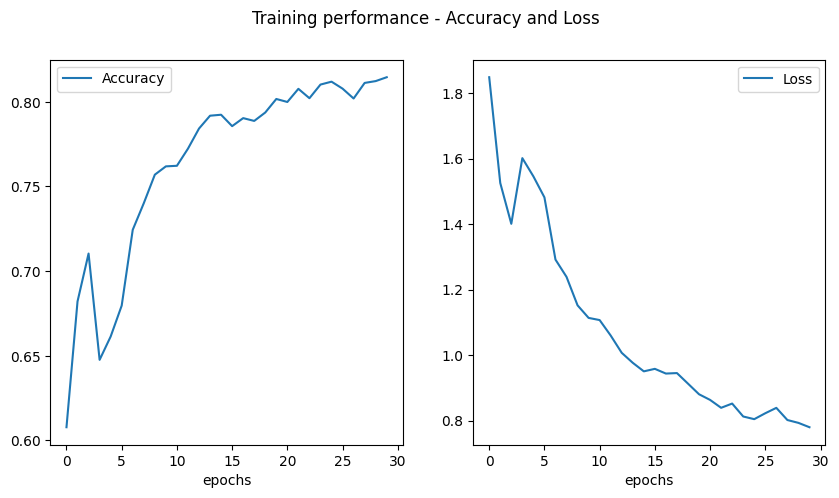

In [75]:
# Get training and validation accuracies
acc = history.history['accuracy']
loss = history.history['loss']

# Get number of epochs
epochs = range(len(acc))

fig, ax = plt.subplots(1, 2, figsize=(10, 5))
fig.suptitle('Training performance - Accuracy and Loss')

for i, (data, label) in enumerate(zip([acc,loss], ["Accuracy", "Loss"])):
    ax[i].plot(epochs, data, label=label)
    ax[i].legend()
    ax[i].set_xlabel('epochs')

If the accuracy meets the requirement of being greater than 80%, then save the `history.pkl` file which contains the information of the training history of your model and will be used to compute your grade. You can do this by running the following code:

In [76]:
with open('history.pkl', 'wb') as f:
    pickle.dump(history.history, f)

## model in action

In [77]:
seed_text = "Help me Obi Wan Kenobi, you're my only hope"
next_words = 100
  
for _ in range(next_words):
    # Convert the text into sequences
    token_list = vectorizer(seed_text)
    # Pad the sequences
    token_list = tf.keras.utils.pad_sequences([token_list], maxlen=max_sequence_len-1, padding='pre')
    # Get the probabilities of predicting a word
    predicted = model.predict([token_list], verbose=0)
    # Choose the next word based on the maximum probability
    predicted = np.argmax(predicted, axis=-1).item()
    # Get the actual word from the word index
    output_word = vectorizer.get_vocabulary()[predicted]
    # Append to the current text
    seed_text += " " + output_word

print(seed_text)

Help me Obi Wan Kenobi, you're my only hope my skill hast end room side nobler defect defect go object that his edge of rolling flatter with kings finding slain forgot them go dearer me be old wish thou catch thy will been brow then bright nights bright see rolling uncertain spring or wrong or wit shadows men night weeds none last that still with thee bright in art back again and me light lie with thee ill doth grow denote with me wrong end back back back and so great wastes sight play have fair more wrong more defect born of our heart breast to thee dumb eye
